In [1]:
# import packages and libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scripts.utils_data import inscription_df
from math import log10
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_validate
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import set_config
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

In [2]:
inscription_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1273 entries, 0 to 1272
Data columns (total 22 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   DATE                                      1273 non-null   object 
 1   MIME_types                                1273 non-null   object 
 2   Inscriptions                              1273 non-null   int64  
 3   Ord_Daily_fees                            1273 non-null   float64
 4   Ord_Size                                  1273 non-null   float64
 5   Ord_vSize                                 1273 non-null   float64
 6   Price                                     1273 non-null   float64
 7   btc_Daily_fee                             1273 non-null   float64
 8   Ord_Daily_fees_USD                        1273 non-null   float64
 9   Ord_Daily_fees_USD_byte                   1273 non-null   float64
 10  Ord_Daily_fees_USD_vbyte            

In [3]:
inscription_df['DATE'] = pd.to_datetime(inscription_df.loc[:,'DATE'])

In [4]:
# Log10 transformation all 3 axes
inscription_df["Ord_Daily_fees_vbyte_Per_Inscription"] = inscription_df.loc[:,"Ord_Daily_fees_vbyte_Per_Inscription"].apply(lambda x: log10(x))
inscription_df.loc[:,"Inscriptions"]= inscription_df.loc[:,"Inscriptions"].apply(lambda x: log10(x))
inscription_df.loc[:,"Ord_vSize_Per_Inscription"]= inscription_df.loc[:,"Ord_vSize_Per_Inscription"].apply(lambda x: log10(x))

# Split data into X and Y
X = inscription_df.loc[:,
                       ["Ord_vSize_Per_Inscription", 
                        "Inscriptions"]]
Y = inscription_df.loc[:,"Ord_Daily_fees_vbyte_Per_Inscription"]


In [5]:
# Remove outlier from the dataset
outlier_idx = list(Y).index(max(Y))
inscription_df.iloc[outlier_idx,:]
X.drop([outlier_idx], inplace = True)
Y.drop([outlier_idx], inplace = True)

In [6]:
# creating train and test sets 
X_train, X_test, y_train, y_test = train_test_split( 
    X, Y, test_size=0.2, random_state=42)

# Create a pipeline
numerical_processor = StandardScaler() # Standardize the data

# Apply the numerical_processor to the numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_processor, ["Ord_vSize_Per_Inscription","Inscriptions"]) 
    ])
steps = [('preprocessor', preprocessor),('reg', LinearRegression())]
pipe = Pipeline(steps)
set_config(display="diagram")
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Ord_vSize_Per_Inscription',
                                                   'Inscriptions'])])),
                ('reg', LinearRegression())])

In [7]:
scores = cross_validate(
    pipe, X_train, y_train, cv=5, scoring=("r2", "neg_mean_squared_error"), return_train_score=True,return_estimator=True,
)
print("Negative Mean squared error: %.2f" % np.mean(scores["test_neg_mean_squared_error"]))
print("R2: %.2f" % np.mean(scores["test_r2"]))

# Get the best estimator based on the mean test score
best_estimator_idx = np.argmax(scores["test_r2"])
best_estimator = scores["estimator"][best_estimator_idx]

print("Best Estimator: \n")
results= {"Features": ["Ord_vSize_Per_Inscription","Inscriptions"],
        "Coefficients": best_estimator["reg"].coef_, 
        "Intercept": best_estimator["reg"].intercept_,}
results_df = pd.DataFrame(results)
print(results_df.head())


Negative Mean squared error: -0.16
R2: 0.95
Best Estimator: 

                    Features  Coefficients  Intercept
0  Ord_vSize_Per_Inscription     -0.172256  -1.190585
1               Inscriptions     -1.818891  -1.190585


In [8]:
# Fit the pipeline to the training data
pipe.fit(X_train, y_train)

# Evaluate the model on the test data
y_pred = pipe.predict(X_test)



In [9]:
# Evaluation metrics for the linear model
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

# Model summary
results = {
    "Features": ["Ord_vSize_Per_Inscription", "Inscriptions"],
    "Coefficients": pipe["reg"].coef_,
    "Intercept": pipe["reg"].intercept_,
}
results_df = pd.DataFrame(results)
print(results_df.head())

Mean squared error: 0.14
Coefficient of determination: 0.96
                    Features  Coefficients  Intercept
0  Ord_vSize_Per_Inscription     -0.155321  -1.228263
1               Inscriptions     -1.833066  -1.228263


<Axes: xlabel='Ord_Daily_fees_vbyte_Per_Inscription', ylabel='Count'>

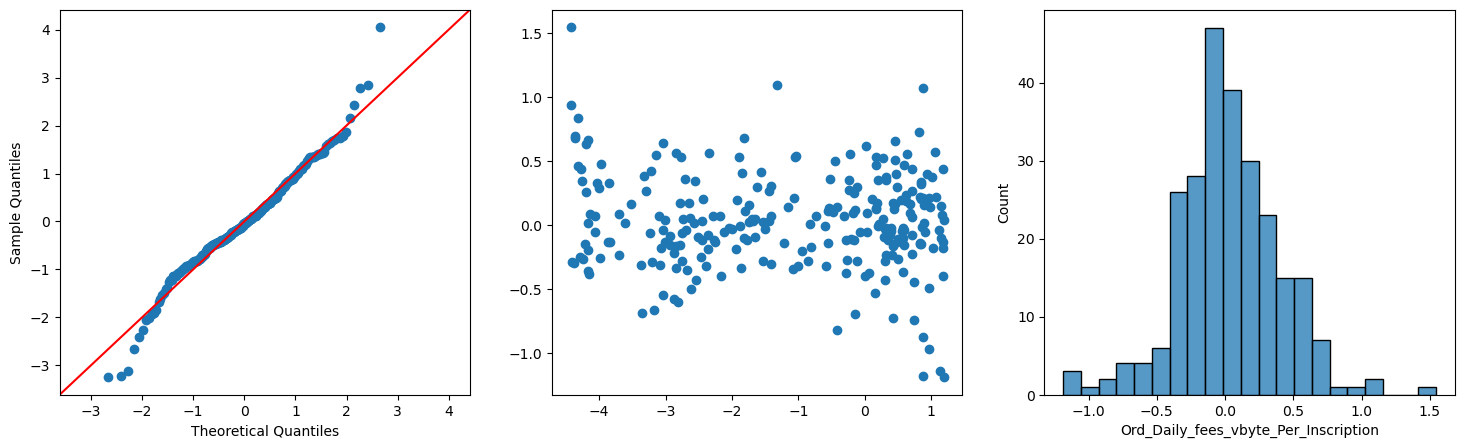

In [10]:
# Plot the residuals
residuals = y_test - y_pred
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sm.qqplot(residuals, ax = axes[0],line="45", fit=True)
axes[1].scatter(y_pred, residuals)
sns.histplot(ax = axes[2],data = residuals)

0.9508068248538194


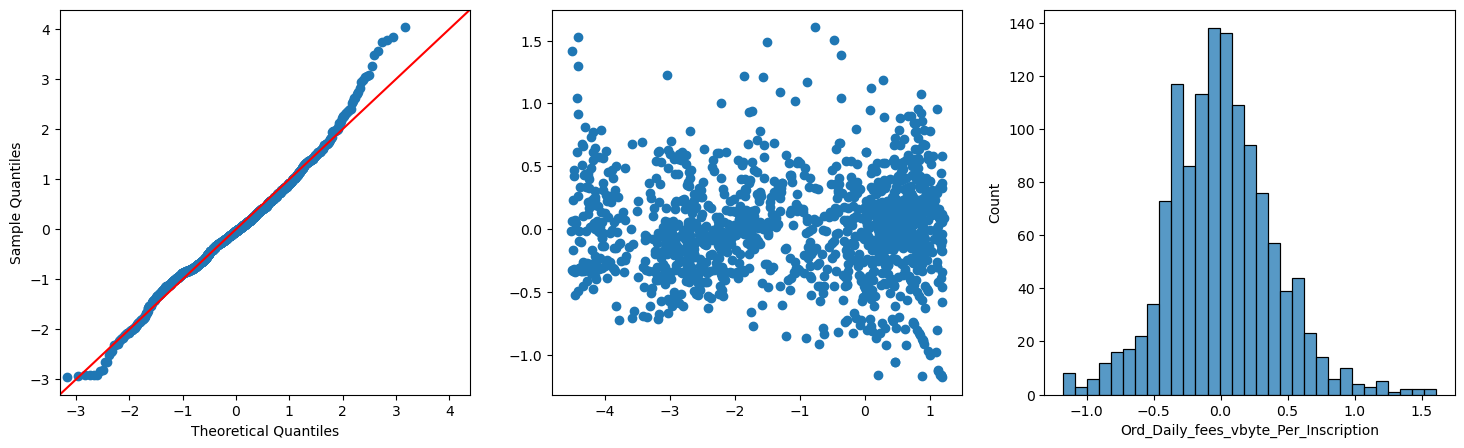

In [11]:
# Fit to entire dataset without splitting
steps = [('preprocessor', preprocessor)]
pipe = Pipeline(steps)
X_t = pipe.fit_transform(X)
reg = LinearRegression()
reg.fit(X_t, Y)
y_pred = reg.predict(X_t)
residuals = Y - y_pred
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sm.qqplot(residuals, ax = axes[0],line="45", fit=True)
axes[1].scatter(y_pred, residuals)
sns.histplot(ax = axes[2],data = residuals)
print(reg.score(X_t, Y))

In [12]:
import plotly.express as px
# Plot the 3D scatter plot
fig = px.scatter_3d(
    data_frame=inscription_df,
    x="Ord_vSize_Per_Inscription",
    y="Inscriptions",
    z="Ord_Daily_fees_vbyte_Per_Inscription",
    color="MIME_types")
fig.update_traces(marker=dict(size=2))
fig.show()